In [19]:
import gymnasium as gym
import pprint
from stable_baselines3 import HerReplayBuffer, SAC
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import os

env = gym.make("parking-v0", render_mode="rgb_array")
env.reset()

print(env.spec)
pprint.pprint(env.config)

EnvSpec(id='parking-v0', entry_point='highway_env.envs:ParkingEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='parking', version=0, additional_wrappers=(), vector_entry_point=None)
{'action': {'type': 'ContinuousAction'},
 'add_walls': True,
 'centering_position': [0.5, 0.5],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'duration': 100,
 'manual_control': False,
 'observation': {'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
                 'normalize': False,
                 'scales': [100, 100, 5, 5, 1, 1],
                 'type': 'KinematicsGoal'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 5,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'scaling': 7,
 'sc

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


Action space: Box(-1.0, 1.0, (2,), float32)
Observation space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))


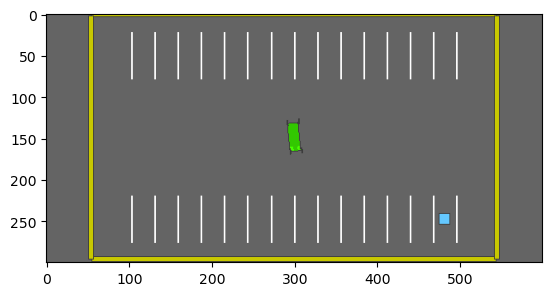

In [20]:
action_space = env.action_space
observation_space = env.observation_space

print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")

plt.imshow(env.render())
plt.show()

In [21]:
class FlattenObservation(gym.Wrapper):
    def _init_(self, env: gym.Env):
        super()._init_(env)

    def observation(self, observation: np.ndarray) -> np.ndarray:
        return observation.flatten()


STEPS = 300 # 1e5
env_train = FlattenObservation(deepcopy(env))
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env_train, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1,
            tensorboard_log=os.path.join("test", "train_hrb_sac_3x256"),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            learning_starts=1000,  
            device="cpu")

model.learn(total_timesteps=int(STEPS))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to test\train_hrb_sac_3x256\SAC_1


In [43]:
import gymnasium as gym
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

env_id = "parking-v0"
video_folder = "logs/videos/"
video_length = 100

vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

obs = vec_env.reset()

# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"random-agent-{env_id}")

vec_env.reset()
for _ in range(video_length + 1):
  action, _ = model.predict(obs, deterministic=True)
  action = [np.array(action.squeeze(), dtype=np.float32)]
  obs, _, _, _ = vec_env.step(action)
# Save the video
vec_env.close()

Saving video to c:\Users\adrie\OneDrive\Bureau\3A CS\Cours IA\RL\RL_project\parking\logs\videos\random-agent-parking-v0-step-0-to-step-100.mp4
Moviepy - Building video c:\Users\adrie\OneDrive\Bureau\3A CS\Cours IA\RL\RL_project\parking\logs\videos\random-agent-parking-v0-step-0-to-step-100.mp4.
Moviepy - Writing video c:\Users\adrie\OneDrive\Bureau\3A CS\Cours IA\RL\RL_project\parking\logs\videos\random-agent-parking-v0-step-0-to-step-100.mp4



TypeError: must be real number, not NoneType